## IMDB Movie Reviews Sentiment Analysis
### Naive Bayes Classifier

#### Reference: https://github.com/satkr7/IMDB-sentiment-analysis-using-naive-bayes

In [54]:
# import packages
import sqlite3
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import string
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter


In [80]:
# load data
data = pd.read_csv('../00_source_data/imdb_master.csv', encoding="ISO-8859-1")
data.head(10)

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt
5,5,test,"A funny thing happened to me while watching ""M...",neg,10004_2.txt
6,6,test,This German horror film has to be one of the w...,neg,10005_2.txt
7,7,test,"Being a long-time fan of Japanese film, I expe...",neg,10006_2.txt
8,8,test,"""Tokyo Eyes"" tells of a 17 year old Japanese g...",neg,10007_4.txt
9,9,test,Wealthy horse ranchers in Buenos Aires have a ...,neg,10008_4.txt


In [56]:
# data preprocessing
# 1. Remove the HTML tags
# 2. Remove any punctuations or a limited set of special characters like, or . or #, etc.
# 3. Check if the word is made up of English letters and is not alpha-numeric
# 4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
# 5. Convert the word to lowercase
# 6. Remove Stopwords (the, and, a ...)
# 7. Finally Snowball Stemming (remove -ing, -ly, ...)

stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]', r'', sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r' ', cleaned)
    return cleaned

In [57]:
i=0
str1=' '
final_string=[]
all_positive_words=[] 
all_negative_words=[] 
s=''
for sent in data['review'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent) 
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (data['label'].values)[i] == "pos": 
                        all_positive_words.append(s) 
                    if(data['label'].values)[i] == "neg":
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) 
    final_string.append(str1)
    i+=1

In [58]:
# add cleaned_review column
data['cleaned_review'] = final_string

In [59]:
# add score column
def posneg(x):
    if x == 'neg':
        return 0
    elif x == 'pos':
        return 1
    return x

filtered_score = data['label'].map(posneg)
data['score'] = filtered_score

In [60]:
# divide data into train and test
train_data = data[25000:50000]
test_data = data[:25000]

In [61]:
X_train = train_data['cleaned_review']
y_train = train_data['score']
X_test = test_data['cleaned_review']
y_test = test_data['score']
y_train = y_train.astype('int')
y_test = y_test.astype('int')

### 1) Using Count Vectorizer

In [62]:
# create a numerical feature vector for each review
count_vect = CountVectorizer()
count_train = count_vect.fit_transform(X_train.values)
count_test = count_vect.transform(X_test.values)

In [63]:
# Naive Bayes: Count
alpha_range_count = list(np.arange(1, 50, 5))
alpha_scores_count = []
for a in alpha_range_count:
    mod = MultinomialNB(alpha=a)
    scores = cross_val_score(mod, count_train, y_train, cv=5, scoring='accuracy')
    alpha_scores_count.append(scores.mean())
    print(a, round(scores.mean(), 4))

1 0.774
6 0.7996
11 0.8079
16 0.8114
21 0.8143
26 0.8171
31 0.8189
36 0.8206
41 0.8219
46 0.8223


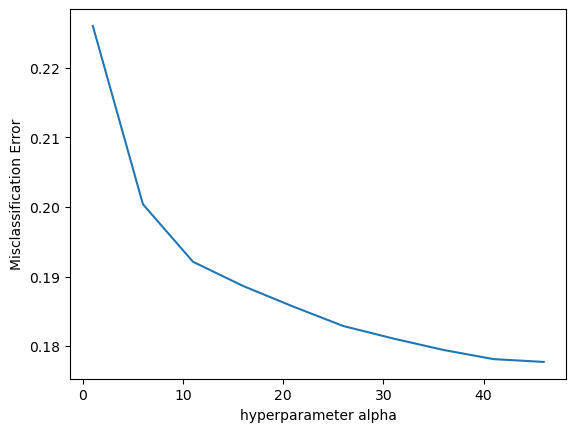

In [64]:
MSE_count = [1 - x for x in alpha_scores_count]
optimal_alpha_count = alpha_range_count[MSE_count.index(min(MSE_count))]

plt.plot(alpha_range_count, MSE_count)
plt.xlabel('hyperparameter alpha')
plt.ylabel('Misclassification Error')
plt.show()

In [65]:
optimal_alpha_count

46

In [66]:
# apply multinomial Naive Bayes
mod_count = MultinomialNB(alpha=optimal_alpha_count)
mod_count.fit(count_train, y_train)

MultinomialNB(alpha=46)

In [67]:
# predict the output using multinomial Naive Bayes classifier
y_pred_count_train = mod_count.predict(count_train)
y_pred_count_test = mod_count.predict(count_test)

In [68]:
# find train accuracy and test accuracy
acc_count_train = accuracy_score(y_train, y_pred_count_train, normalize=True) * float(100)
acc_count_test = accuracy_score(y_test, y_pred_count_test, normalize=True) * float(100)
print('The accuracy of the Naive Bayes classifier for train dataset is {:.2f}%.'.format(acc_count_train))
print('The accuracy of the Naive Bayes classifier for test dataset is {:.2f}%.'.format(acc_count_test))

The accuracy of the Naive Bayes classifier for train dataset is 86.43%.
The accuracy of the Naive Bayes classifier for test dataset is 83.45%.


### 2) Using TF-IDF Vectorizer

In [69]:
# create a numerical feature vector for each review
tfidf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tfidf_vect.fit_transform(X_train.values)
tfidf_test = tfidf_vect.transform(X_test.values)

In [70]:
# Naive Bayes: TF-IDF
alpha_range_tfidf = list(np.arange(1, 50, 5))
alpha_scores_tfidf = []
for a in alpha_range_tfidf:
    mod = MultinomialNB(alpha=a)
    scores = cross_val_score(mod, tfidf_train, y_train, cv=5, scoring='accuracy')
    alpha_scores_tfidf.append(scores.mean())
    print(a, round(scores.mean(), 4))

1 0.8302
6 0.8356
11 0.834
16 0.8324
21 0.8313
26 0.8299
31 0.8288
36 0.8274
41 0.8258
46 0.8245


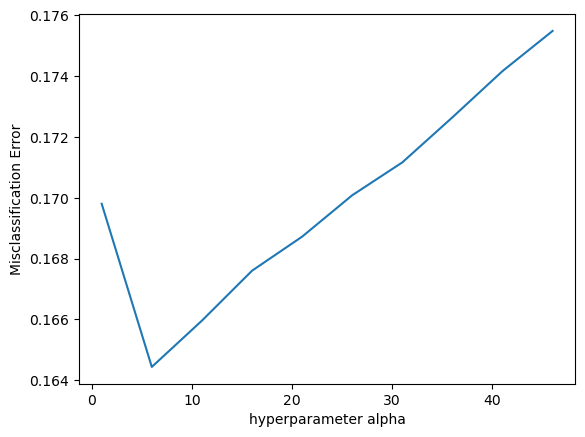

In [71]:
MSE_tfidf = [1 - x for x in alpha_scores_tfidf]
optimal_alpha_tfidf = alpha_range_tfidf[MSE_tfidf.index(min(MSE_tfidf))]

plt.plot(alpha_range_tfidf, MSE_tfidf)
plt.xlabel('hyperparameter alpha')
plt.ylabel('Misclassification Error')
plt.show()

In [72]:
optimal_alpha_tfidf

6

In [73]:
# apply multinomial Naive Bayes
mod_tfidf = MultinomialNB(alpha=optimal_alpha_tfidf)
mod_tfidf.fit(tfidf_train, y_train)

MultinomialNB(alpha=6)

In [74]:
# predict the output using multinomial Naive Bayes classifier
y_pred_tfidf_train = mod_tfidf.predict(tfidf_train)
y_pred_tfidf_test = mod_tfidf.predict(tfidf_test)

In [75]:
# find train accuracy and test accuracy
acc_tfidf_train = accuracy_score(y_train, y_pred_tfidf_train, normalize=True) * float(100)
acc_tfidf_test = accuracy_score(y_test, y_pred_tfidf_test, normalize=True) * float(100)
print('The accuracy of the Naive Bayes classifier for train dataset is {:.2f}%.'.format(acc_tfidf_train))
print('The accuracy of the Naive Bayes classifier for test dataset is {:.2f}%.'.format(acc_tfidf_test))

The accuracy of the Naive Bayes classifier for train dataset is 93.63%.
The accuracy of the Naive Bayes classifier for test dataset is 85.51%.


In [76]:
# plot a confusion matrix for train dataset
cm_tfidf_train = confusion_matrix(y_train, y_pred_tfidf_train)
print(cm_tfidf_train)

[[11828   672]
 [  921 11579]]


<AxesSubplot: >

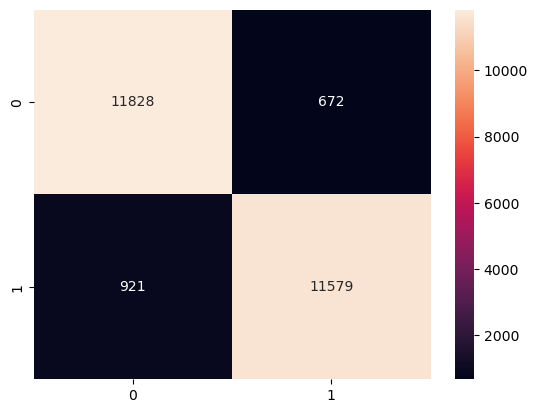

In [77]:
# plot a heatmap for train dataset
sns.heatmap(cm_tfidf_train, annot=True, fmt='d')

In [78]:
# plot a confusion matrix for test dataset
cm_tfidf_test = confusion_matrix(y_test, y_pred_tfidf_test)
print(cm_tfidf_test)

[[11139  1361]
 [ 2262 10238]]


<AxesSubplot: >

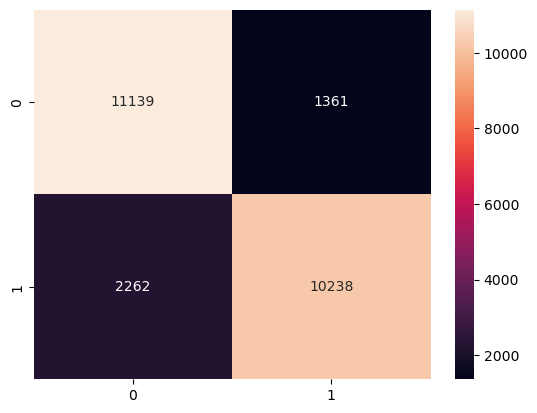

In [79]:
# plot a heatmap for test dataset
sns.heatmap(cm_tfidf_test, annot=True, fmt='d')